In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
train_data_path = '../cartoon'
SAVE_LOC = 'VAE.pth'
BATCH_SIZE = 64
EPOCH = 1500
INPUT_SIZE = 256

train_transform = transforms.Compose(
    [transforms.Resize((INPUT_SIZE,INPUT_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = torchvision.datasets.ImageFolder(
    root = train_data_path,
    transform = train_transform
    )
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([64, 3, 256, 256])


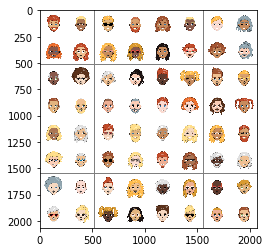

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 7, padding = 3)
        self.pool1 = nn.MaxPool2d(4, 4, return_indices=True)
        self.conv2 = nn.Conv2d(6, 16, 5, padding = 2)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv3 = nn.Conv2d(16, 32, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True)
        self.fc1 = nn.Linear(32 * 16 * 16, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 50)
        
        self.indices1 = 0
        self.indices2 = 0
        self.indices3 = 0

        self.rconv1 = nn.ConvTranspose2d(6, 3, 7, padding = 3)
        self.rpool1 = nn.MaxUnpool2d(4, 4)
        self.rconv2 = nn.ConvTranspose2d(16, 6, 5, padding = 2)
        self.rpool2 = nn.MaxUnpool2d(2, 2)
        self.rconv3 = nn.ConvTranspose2d(32, 16, 3, padding = 1)
        self.rpool3 = nn.MaxUnpool2d(2, 2)
        self.rfc1 = nn.Linear(2048, 32 * 16 * 16)
        self.rfc2 = nn.Linear(512, 2048)
        self.rfc3 = nn.Linear(50, 512)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x): #3, 256, 256
        x = F.relu(self.conv1(x)) #6, 256, 256
        x, self.indices1 = self.pool1(x) #6, 64, 64 
        x = F.relu(self.conv2(x)) #16, 64, 64
        x, self.indices2 = self.pool2(x) #16, 32, 32
        x = F.relu(self.conv3(x)) #32, 32, 32
        x, self.indices3 = self.pool3(x) #32, 16, 16
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc3(x)
        var = self.fc3(x)
        return mean, var
    
    def decode(self, x):
        x = F.relu(self.rfc3(x))
        x = F.relu(self.rfc2(x))
        x = F.relu(self.rfc1(x))
        x = x.view(x.size(0), 32, 16, 16)
        x = self.rpool3(x, self.indices3)
        x = F.relu(self.rconv3(x))
        x = self.rpool2(x, self.indices2)
        x = F.relu(self.rconv2(x))
        x = self.rpool1(x, self.indices1)
        x = self.rconv1(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


net = VAE()
if torch.cuda.is_available():
    net = net.cuda()

In [7]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [9]:
loss_value = []

for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, mu, logvar = net(inputs)
        loss = loss_function(outputs, inputs, mu, logvar)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    ls = running_loss / len(trainloader)
    loss_value.append(ls)
    print('Epoch', epoch, 'with loss of', ls)

print('Finished Training')

Epoch 0 with loss of 6965380.245621019
Epoch 1 with loss of 1941196.2816480892
Epoch 2 with loss of 1619300.7330812102
Epoch 3 with loss of 1392349.6474920383
Epoch 4 with loss of 1247756.4530254777
Epoch 5 with loss of 1154469.798566879
Epoch 6 with loss of 1084213.6261942675
Epoch 7 with loss of 1028641.2873208598
Epoch 8 with loss of 977756.6516719746
Epoch 9 with loss of 931926.9325238854
Epoch 10 with loss of 893453.8742038216
Epoch 11 with loss of 861955.3070262739
Epoch 12 with loss of 836131.4046576433
Epoch 13 with loss of 811495.5675756369
Epoch 14 with loss of 791047.851214172
Epoch 15 with loss of 772489.3445461784
Epoch 16 with loss of 757474.1529657643
Epoch 17 with loss of 744955.5901671974
Epoch 18 with loss of 732429.5520501592
Epoch 19 with loss of 719961.1135549363
Epoch 20 with loss of 711468.0803144905
Epoch 21 with loss of 702753.3318073249
Epoch 22 with loss of 693196.2966759554
Epoch 23 with loss of 684083.2402468153
Epoch 24 with loss of 679768.4073447452
Epoch

Epoch 202 with loss of 245215.06160429935
Epoch 203 with loss of 243574.77301453025
Epoch 204 with loss of 246140.5758857484
Epoch 205 with loss of 246163.7777169586
Epoch 206 with loss of 244847.3483280255
Epoch 207 with loss of 243558.89032643312
Epoch 208 with loss of 244675.15296576434
Epoch 209 with loss of 245903.68120521496
Epoch 210 with loss of 244309.6291052946
Epoch 211 with loss of 248327.1761544586
Epoch 212 with loss of 246703.3517615446
Epoch 213 with loss of 245131.68558419586
Epoch 214 with loss of 244373.619053543
Epoch 215 with loss of 243626.01659534237
Epoch 216 with loss of 243489.43772392516
Epoch 217 with loss of 242923.3923915207
Epoch 218 with loss of 243004.9808419586
Epoch 219 with loss of 241023.18533539012
Epoch 220 with loss of 240817.58198148885
Epoch 221 with loss of 249424.3483280255
Epoch 222 with loss of 244515.69862161623
Epoch 223 with loss of 242591.337803543
Epoch 224 with loss of 240221.68565883758
Epoch 225 with loss of 240785.17896596337
Epoch

Epoch 399 with loss of 220026.22220839967
Epoch 400 with loss of 221595.630946457
Epoch 401 with loss of 220356.62793590763
Epoch 402 with loss of 220563.75806130574
Epoch 403 with loss of 221639.34825338377
Epoch 404 with loss of 219653.7593053344
Epoch 405 with loss of 223878.1650079618
Epoch 406 with loss of 220512.0474472532
Epoch 407 with loss of 219503.03809215763
Epoch 408 with loss of 220980.0006468949
Epoch 409 with loss of 263891.1567476115
Epoch 410 with loss of 242487.45073646496
Epoch 411 with loss of 234710.81879478504
Epoch 412 with loss of 232503.3412370621
Epoch 413 with loss of 230830.31536126594
Epoch 414 with loss of 229127.39746715763
Epoch 415 with loss of 225473.83123507164
Epoch 416 with loss of 223978.9511843153
Epoch 417 with loss of 224331.60708598726
Epoch 418 with loss of 221961.78129976115
Epoch 419 with loss of 220836.39244128185
Epoch 420 with loss of 221680.83252886147
Epoch 421 with loss of 220475.12485071656
Epoch 422 with loss of 220377.8782593551
Ep

Epoch 596 with loss of 208970.3273785828
Epoch 597 with loss of 207929.1844396895
Epoch 598 with loss of 207469.0045531449
Epoch 599 with loss of 208853.8185459793
Epoch 600 with loss of 207210.32471636147
Epoch 601 with loss of 211599.78463375795
Epoch 602 with loss of 209441.76089769107
Epoch 603 with loss of 208835.6756817277
Epoch 604 with loss of 209662.95640923566
Epoch 605 with loss of 209596.23785828025
Epoch 606 with loss of 211124.177821457
Epoch 607 with loss of 208344.8368829618
Epoch 608 with loss of 208555.7467406449
Epoch 609 with loss of 208146.50544884554
Epoch 610 with loss of 206643.03585290606
Epoch 611 with loss of 206590.9520302548
Epoch 612 with loss of 206450.13413117037
Epoch 613 with loss of 206088.79918889332
Epoch 614 with loss of 210347.0741192277
Epoch 615 with loss of 208019.25
Epoch 616 with loss of 208150.26383359873
Epoch 617 with loss of 207131.70225417992
Epoch 618 with loss of 208351.25164211783
Epoch 619 with loss of 207440.99270999205
Epoch 620 wi

Epoch 793 with loss of 200376.05511046975
Epoch 794 with loss of 200007.47362659237
Epoch 795 with loss of 205072.08461882963
Epoch 796 with loss of 200500.18404160033
Epoch 797 with loss of 201053.31088276274
Epoch 798 with loss of 199868.92757265127
Epoch 799 with loss of 200111.64012738853
Epoch 800 with loss of 200504.01706807324
Epoch 801 with loss of 200167.88062300955
Epoch 802 with loss of 201376.64627289012
Epoch 803 with loss of 200252.4350617038
Epoch 804 with loss of 200931.47696058918
Epoch 805 with loss of 199384.68272292992
Epoch 806 with loss of 200624.32464171975
Epoch 807 with loss of 201201.90769307324
Epoch 808 with loss of 199024.24559613853
Epoch 809 with loss of 199114.25589669586
Epoch 810 with loss of 199521.8857732882
Epoch 811 with loss of 199724.96205712578
Epoch 812 with loss of 200840.52998109077
Epoch 813 with loss of 240422.96282842357
Epoch 814 with loss of 207137.4000049761
Epoch 815 with loss of 203561.92918988853
Epoch 816 with loss of 200980.8351910

Epoch 990 with loss of 202655.1620969347
Epoch 991 with loss of 196758.56804836783
Epoch 992 with loss of 196998.04393909237
Epoch 993 with loss of 196025.87606986464
Epoch 994 with loss of 196577.22141222135
Epoch 995 with loss of 196690.66520700636
Epoch 996 with loss of 196056.64079916402
Epoch 997 with loss of 196943.15911126594
Epoch 998 with loss of 196584.04784534237
Epoch 999 with loss of 197180.14709394905
Epoch 1000 with loss of 197435.2454468551
Epoch 1001 with loss of 197654.9344396895
Epoch 1002 with loss of 196413.89487957803
Epoch 1003 with loss of 197588.51288813693
Epoch 1004 with loss of 196619.22240744426
Epoch 1005 with loss of 197905.21496815287
Epoch 1006 with loss of 196914.17087977708
Epoch 1007 with loss of 196220.4545183121
Epoch 1008 with loss of 198110.99335688693
Epoch 1009 with loss of 196361.1462977707
Epoch 1010 with loss of 196023.4975617038
Epoch 1011 with loss of 198580.12348228504
Epoch 1012 with loss of 197627.3395700637
Epoch 1013 with loss of 1980

Epoch 1183 with loss of 192869.80436405254
Epoch 1184 with loss of 194468.63938097135
Epoch 1185 with loss of 194592.56374402865
Epoch 1186 with loss of 192617.0498357882
Epoch 1187 with loss of 193567.45668292197
Epoch 1188 with loss of 192895.60191082803
Epoch 1189 with loss of 193034.4652169586
Epoch 1190 with loss of 193944.75104498406
Epoch 1191 with loss of 193477.5930035828
Epoch 1192 with loss of 193170.8900527468
Epoch 1193 with loss of 193773.55461285828
Epoch 1194 with loss of 195913.07387042197
Epoch 1195 with loss of 194653.56043491242
Epoch 1196 with loss of 193802.0449094347
Epoch 1197 with loss of 193582.26360967357
Epoch 1198 with loss of 193762.59046576434
Epoch 1199 with loss of 193144.73492237262
Epoch 1200 with loss of 192526.8656946656
Epoch 1201 with loss of 194362.6713027468
Epoch 1202 with loss of 194031.11982484077
Epoch 1203 with loss of 198531.59611365446
Epoch 1204 with loss of 195289.79801950636
Epoch 1205 with loss of 199534.53361365446
Epoch 1206 with lo

Epoch 1376 with loss of 193457.08098626594
Epoch 1377 with loss of 192005.61559514332
Epoch 1378 with loss of 191888.70874800955
Epoch 1379 with loss of 194244.11502289012
Epoch 1380 with loss of 195316.08170780254
Epoch 1381 with loss of 196238.78764430733
Epoch 1382 with loss of 193490.0435410032
Epoch 1383 with loss of 192236.94964171975
Epoch 1384 with loss of 192488.75778761943
Epoch 1385 with loss of 192389.42443769905
Epoch 1386 with loss of 193104.99188893312
Epoch 1387 with loss of 192093.82190485668
Epoch 1388 with loss of 193173.64913415606
Epoch 1389 with loss of 192660.74261046975
Epoch 1390 with loss of 191486.4846486863
Epoch 1391 with loss of 191644.4503134952
Epoch 1392 with loss of 197693.52856289808
Epoch 1393 with loss of 194096.46703324045
Epoch 1394 with loss of 192027.89264032643
Epoch 1395 with loss of 193807.829991043
Epoch 1396 with loss of 193265.2589072452
Epoch 1397 with loss of 192441.6435111465
Epoch 1398 with loss of 193572.47315386147
Epoch 1399 with lo

In [10]:
torch.save(net.state_dict(), SAVE_LOC)

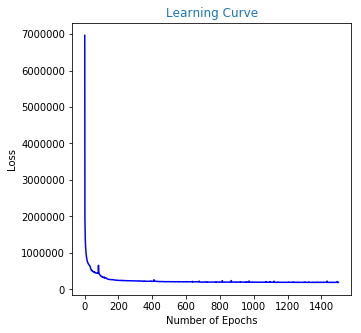

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Learning Curve'.format('default'), color='C0')
ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(loss_value))), loss_value, 'b')

In [19]:
import numpy as np

device = torch.device("cuda")
net = VAE()
net.load_state_dict(torch.load(SAVE_LOC))
net.to(device)

with torch.no_grad():
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
        
    outputs, mu, logvar = net(images)    
    # show images
    torchvision.utils.save_image(images.cpu() * 0.5 + 0.5, "input_image.jpg", padding=0)
    torchvision.utils.save_image(outputs.cpu() * 0.5 + 0.5, "output_image.jpg", padding=0)
    
with torch.no_grad():
    sample_mean = np.random.uniform(-1, 1, (BATCH_SIZE, 50))
    sample_mean = torch.tensor(sample_mean, dtype=torch.float32)
    sample_var = np.random.uniform(-1, 1, (BATCH_SIZE, 50))
    sample_var = torch.tensor(sample_var, dtype=torch.float32)

    if torch.cuda.is_available():
        sample_mean = sample_mean.cuda()
        sample_var = sample_var.cuda()
        
    outputs = net.reparameterize(sample_mean, sample_var)
    outputs = net.decode(outputs)
    # show images
    torchvision.utils.save_image(outputs.cpu() * 0.5 + 0.5, "sample_prior_image.jpg", padding=0)